/var/folders/6v/kpy52bz12cv4m_cl3kz_4hsm0000gn/T/ipykernel_35301/434520687.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_train = torch.tensor(t_train, dtype=torch.float32, requires_grad=True)
/var/folders/6v/kpy52bz12cv4m_cl3kz_4hsm0000gn/T/ipykernel_35301/434520687.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_train = torch.tensor(s_train, dtype=torch.float32)
/var/folders/6v/kpy52bz12cv4m_cl3kz_4hsm0000gn/T/ipykernel_35301/434520687.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_phys = torch.tensor(t_phys, dtyp

Epoch 0, Data Loss: 1382.71337890625, Phys Loss: 48.111732482910156, Init Loss: 719.7951049804688, S0 Loss: 0.004491375759243965, L2 Loss: 255.4105987548828, Total Loss: 691.356689453125
Epoch 100, Data Loss: 1066.29345703125, Phys Loss: 52.76982879638672, Init Loss: 641.0319213867188, S0 Loss: 0.06586837023496628, L2 Loss: 258.8050842285156, Total Loss: 533.146728515625
Epoch 200, Data Loss: 184.32469177246094, Phys Loss: 260.744140625, Init Loss: 170.3744659423828, S0 Loss: 12.029619216918945, L2 Loss: 272.19989013671875, Total Loss: 92.16234588623047
Epoch 300, Data Loss: 151.5952911376953, Phys Loss: 299.162353515625, Init Loss: 144.20980834960938, S0 Loss: 20.20162582397461, L2 Loss: 275.37127685546875, Total Loss: 75.79764556884766
Epoch 400, Data Loss: 132.82479858398438, Phys Loss: 301.76849365234375, Init Loss: 152.8555450439453, S0 Loss: 24.441631317138672, L2 Loss: 280.4854736328125, Total Loss: 66.41239929199219
Epoch 500, Data Loss: 111.4552001953125, Phys Loss: 354.421813

Epoch 4300, Data Loss: 0.021186111494898796, Phys Loss: 10017.4931640625, Init Loss: 195.515380859375, S0 Loss: 0.02982122264802456, L2 Loss: 291.1115417480469, Total Loss: 0.010593055747449398
Epoch 4400, Data Loss: 0.02080138772726059, Phys Loss: 10039.111328125, Init Loss: 197.724609375, S0 Loss: 0.030169976875185966, L2 Loss: 290.0918884277344, Total Loss: 0.010400693863630295
Epoch 4500, Data Loss: 0.020439868792891502, Phys Loss: 10058.25, Init Loss: 200.03927612304688, S0 Loss: 0.030547719448804855, L2 Loss: 289.0402526855469, Total Loss: 0.010219934396445751
Epoch 4600, Data Loss: 0.020094912499189377, Phys Loss: 10074.623046875, Init Loss: 202.45956420898438, S0 Loss: 0.03095257841050625, L2 Loss: 287.95654296875, Total Loss: 0.010047456249594688
Epoch 4700, Data Loss: 0.019760116934776306, Phys Loss: 10087.966796875, Init Loss: 204.98837280273438, S0 Loss: 0.03138480708003044, L2 Loss: 286.8409118652344, Total Loss: 0.009880058467388153
Epoch 4800, Data Loss: 0.01942873559892

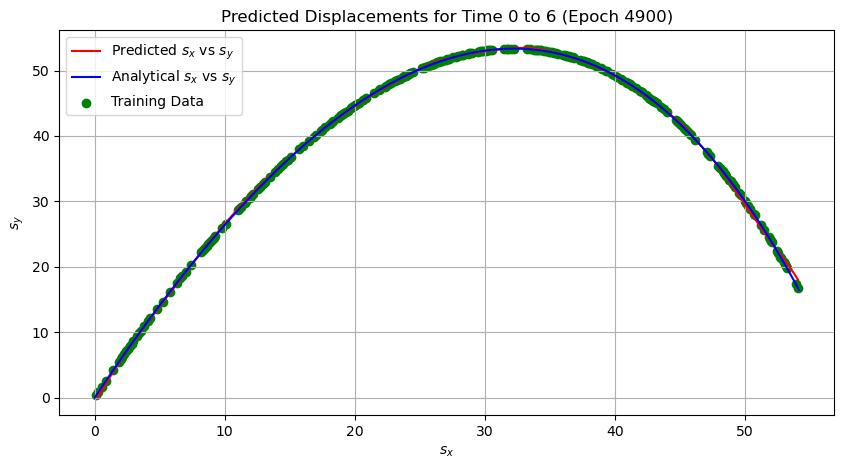

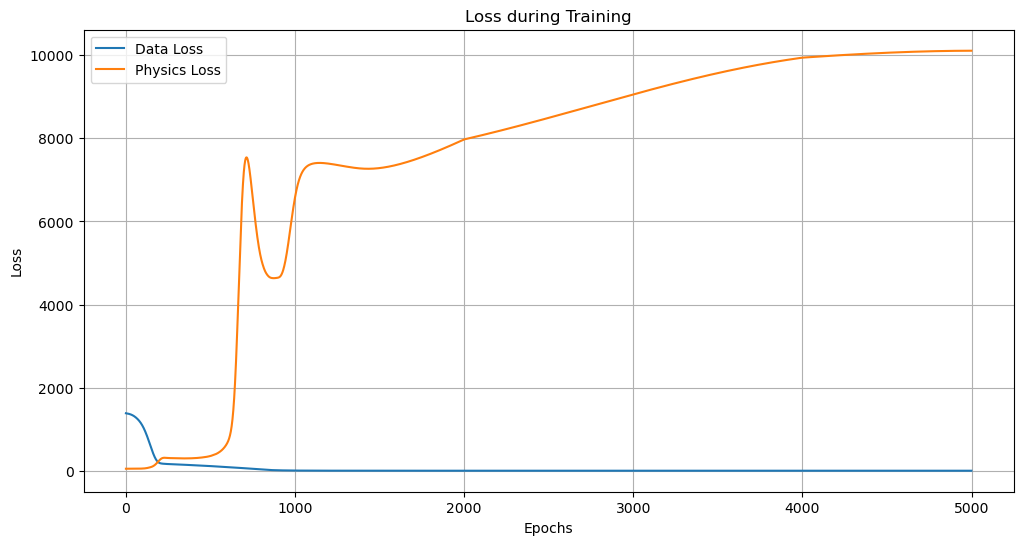

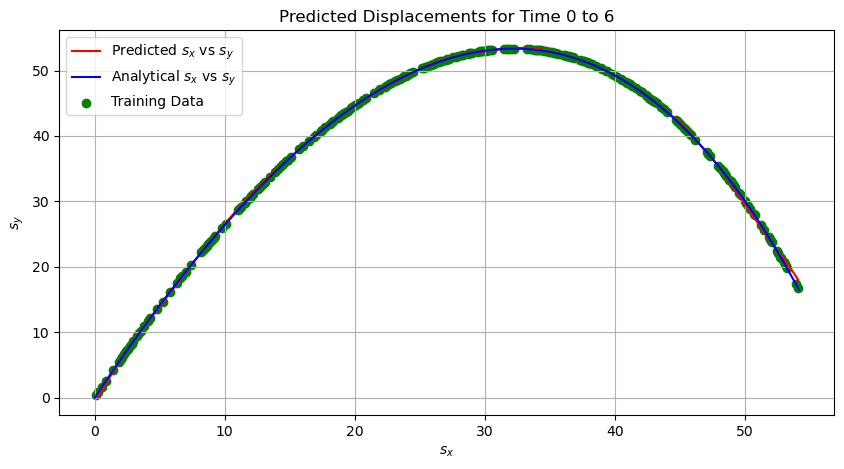

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

# Definir la red neuronal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 256)  # Capa de entrada con 10 neuronas
        self.fc2 = nn.Linear(256, 128)  # Capa oculta con 20 neuronas
        self.fc3 = nn.Linear(128, 64)  # Capa oculta con 20 neuronas
        self.fc4 = nn.Linear(64, 32)  # Capa oculta con 20 neuronas
        self.fc5 = nn.Linear(32, 2)  # Capa de salida con 2 neuronas (para s_x y s_y)
    
    def forward(self, t):
        x = torch.nn.functional.gelu(self.fc1(t))
        x = torch.nn.functional.gelu(self.fc2(x))
        x = torch.nn.functional.gelu(self.fc3(x))
        x = torch.nn.functional.gelu(self.fc4(x))
        s_hat = self.fc5(x)
        return s_hat

# Crear una instancia de la red y definir el optimizador
net = Net()
mu = torch.tensor(0.10, requires_grad=True)
data_weight = 0.50
phys_weight = 1.0
init_weight = 1.0
s0_weight = 1.0
l2_weight = 0.01  # Factor de penalización L2
optimizer = optim.Adam(list(net.parameters()) + [mu], lr=0.0001, weight_decay=l2_weight)  # Incluir weight_decay

# Condiciones iniciales
v0x = 12  # velocidad inicial en x en m/s
v0y = 36  # velocidad inicial en y en m/s

# Inicializar t0 fuera de la función de entrenamiento
t0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)

def train(t_train, s_train, t_phys, v0x, v0y):
    net.train()
    
    t_train = torch.tensor(t_train, dtype=torch.float32, requires_grad=True)
    s_train = torch.tensor(s_train, dtype=torch.float32)
    t_phys = torch.tensor(t_phys, dtype=torch.float32, requires_grad=True)
    
    # Data loss
    s_train_hat = net(t_train)
    data_loss = nn.MSELoss()(s_train_hat, s_train)
    
    # Physics loss
    s_phys_hat = net(t_phys)
    s_x, s_y = s_phys_hat[:, 0], s_phys_hat[:, 1]
    
    v_x = torch.autograd.grad(s_x, t_phys, torch.ones_like(s_x), create_graph=True)[0]
    v_y = torch.autograd.grad(s_y, t_phys, torch.ones_like(s_y), create_graph=True)[0]
    
    a_x = torch.autograd.grad(v_x, t_phys, torch.ones_like(v_x), create_graph=True)[0]
    a_y = torch.autograd.grad(v_y, t_phys, torch.ones_like(v_y), create_graph=True)[0]
    
    v = torch.cat([v_x, v_y], dim=1)
    a = torch.cat([a_x, a_y], dim=1)
    
    v = v.detach()
    
    speed = torch.norm(v, dim=1, keepdim=True)
    g = torch.tensor([[0.0, 9.81]], dtype=torch.float32)
    
    physics_residual = -mu * speed * v - g - a
    phys_loss = nn.MSELoss()(physics_residual, torch.zeros_like(physics_residual))

    # Initial condition loss for velocities
    s0_hat = net(t0)
    v0_hat = torch.autograd.grad(s0_hat, t0, torch.ones_like(s0_hat), create_graph=True)[0]
    init_loss = nn.MSELoss()(v0_hat, torch.tensor([[v0x, v0y]], dtype=torch.float32))

    # Initial condition loss for positions
    s0_loss = nn.MSELoss()(s0_hat, torch.tensor([[0.0, 0.0]], dtype=torch.float32))

    # L2 regularization loss
    l2_loss = sum(torch.norm(param) ** 2 for param in net.parameters())  # Suma de las normas L2 de los parámetros
    
    # Total loss
    loss = (data_weight * data_loss)# + phys_weight * phys_loss)
    
    # Gradient step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return data_loss.item(), phys_loss.item(), init_loss.item(), s0_loss.item(), l2_loss.item(), loss.item()

# Leer el archivo CSV
#data = pd.read_csv('proyectil_datos_seleccionados.csv')
data = pd.read_csv('proyectil_datos_full.csv')

# Separar las columnas en tiempo (t) y desplazamientos (s_x, s_y)
t_train = torch.tensor(data.iloc[:, 0].values.reshape(-1, 1), dtype=torch.float32)
s_train = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32)

# Ejemplo de t_phys: se puede ajustar según las necesidades del problema
t_phys = torch.linspace(0, 5.9, 10).reshape(-1, 1)

# Número de épocas de entrenamiento
num_epochs = 5000

# Listas para almacenar las pérdidas durante el entrenamiento
data_losses = []
phys_losses = []
init_losses = []
s0_losses = []
l2_losses = []
total_losses = []

import torch.optim.lr_scheduler as lr_scheduler

# Crear un scheduler que reduzca la tasa de aprendizaje por un factor de 0.1 después de 2000 épocas
scheduler = lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

# Almacenamiento para animación
frames = []
times = np.linspace(0, 6, 100)

# Función de posición analítica del proyectil
def projectile_position(t, m, b, v0x, v0y, x0, y0, g=9.81):
    xt = (m * v0x / b) * (1 - np.exp(-b * t / m)) + x0
    yt = ((m / b) * (v0y + (m * g / b)) * (1 - np.exp(-b * t / m))) - (m * g * t / b) + y0
    return xt, yt

# Generar datos analíticos para comparación
analytical_positions = [projectile_position(t, 1, 0.1, v0x, v0y, 0.0, 0.0) for t in times]

# Función para actualizar la animación
def update(epoch):
    ax.clear()
    net.eval()
    t_test = torch.tensor(times.reshape(-1, 1), dtype=torch.float32)

    with torch.no_grad():
        s_test_pred = net(t_test).numpy()

    ax.plot(s_test_pred[:, 0], s_test_pred[:, 1], label='Predicted $s_x$ vs $s_y$', color='red')
    ax.plot([pos[0] for pos in analytical_positions], [pos[1] for pos in analytical_positions], label='Analytical $s_x$ vs $s_y$', color='blue')
    ax.scatter(s_train[:, 0], s_train[:, 1], color='green', label='Training Data')
    ax.set_xlabel('$s_x$')
    ax.set_ylabel('$s_y$')
    ax.legend()
    ax.set_title(f'Predicted Displacements for Time 0 to 6 (Epoch {epoch})')
    ax.grid(True)

# Ejemplo de entrenamiento
for epoch in range(num_epochs):
    data_loss, phys_loss, init_loss, s0_loss, l2_loss, total_loss = train(t_train, s_train, t_phys, v0x, v0y)
    data_losses.append(data_loss)
    phys_losses.append(phys_loss)
    init_losses.append(init_loss)
    s0_losses.append(s0_loss)
    l2_losses.append(l2_loss)
    total_losses.append(total_loss)
    scheduler.step()  # Llamar al método step() del scheduler en cada época
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Data Loss: {data_loss}, Phys Loss: {phys_loss}, Init Loss: {init_loss}, S0 Loss: {s0_loss}, L2 Loss: {l2_loss}, Total Loss: {total_loss}')
        frames.append(epoch)

# Crear la animación usando FuncAnimation
fig, ax = plt.subplots(figsize=(10, 5))
ani = animation.FuncAnimation(fig, update, frames=frames, repeat_delay=1000)
writer = animation.PillowWriter(fps=10)
ani.save("training_animation.gif", writer=writer)

# Visualizar las pérdidas
plt.figure(figsize=(12, 6))
plt.plot(data_losses, label='Data Loss')
plt.plot(phys_losses, label='Physics Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during Training')
plt.grid(True)
plt.show()

# Visualizar los resultados finales
net.eval()
times = np.linspace(0, 6, 1000)
t_test = torch.tensor(times.reshape(-1, 1), dtype=torch.float32)

with torch.no_grad():
    s_test_pred = net(t_test).numpy()

plt.figure(figsize=(10, 5))
plt.plot(s_test_pred[:, 0], s_test_pred[:, 1], label='Predicted $s_x$ vs $s_y$', color='red')
plt.plot([pos[0] for pos in analytical_positions], [pos[1] for pos in analytical_positions], label='Analytical $s_x$ vs $s_y$', color='blue')
plt.scatter(s_train[:, 0], s_train[:, 1], color='green', label='Training Data')
plt.xlabel('$s_x$')
plt.ylabel('$s_y$')
plt.legend()
plt.title('Predicted Displacements for Time 0 to 6')
plt.grid(True)
plt.show()


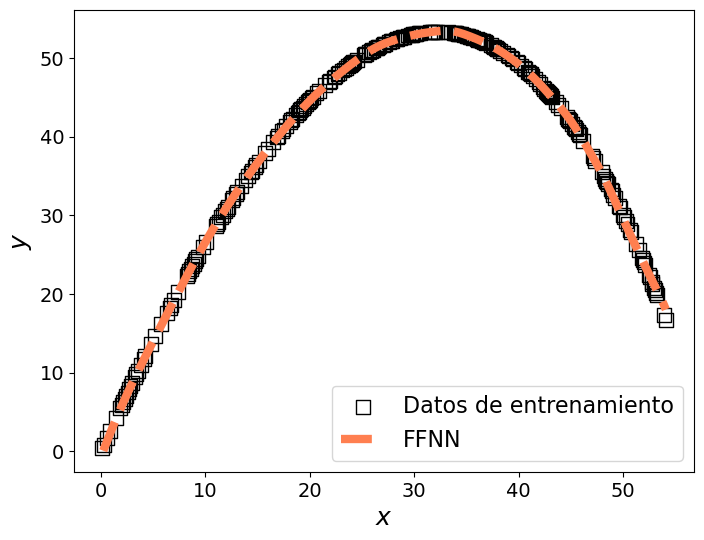

In [72]:
plt.figure(figsize=(8, 6))
plt.scatter(s_train[:, 0], s_train[:, 1], marker='s', facecolors='none', edgecolors='k', s=100, label='Datos de entrenamiento')

#plt.plot([pos[0] for pos in analytical_positions], [pos[1] for pos in analytical_positions], lw = 8,label='Analítica', color='coral')
plt.plot(s_test_pred[:, 0], s_test_pred[:, 1], label='FFNN',color='coral',lw= 6, linestyle ='--')
plt.xlabel('$x$', fontsize =18)
plt.ylabel('$y$', fontsize =18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='lower right', fontsize = 16)
plt.savefig('ProjectilFFNNM_fulldata.png')
plt.grid(False)
plt.show()


23.09166666666667

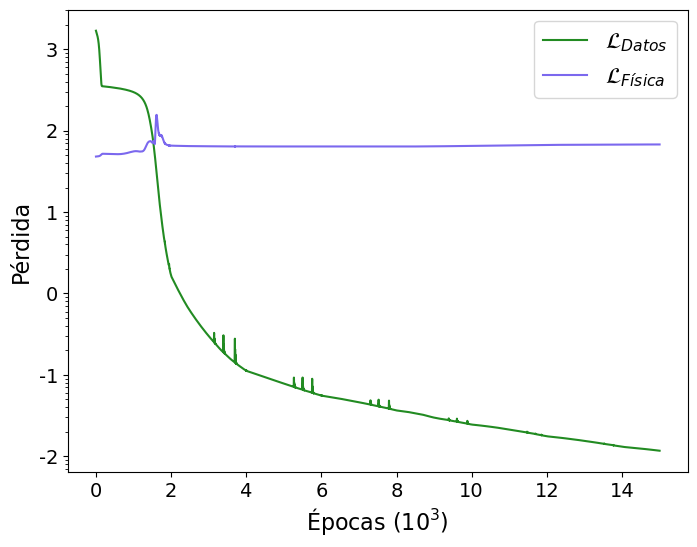

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter

# Función para formatear las etiquetas del eje y
def log_format(exponent, pos):
    return f"{int(np.log10(exponent))}"  # Extraer el exponente como entero

# Función para formatear las etiquetas del eje x
def x_format(value, pos):
    return f"{int(value / 1000)}"  # Convertir a miles

# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.plot(data_losses, color='forestgreen', label=r'$\mathcal{L}_{Datos}$')
plt.plot(phys_losses, color='mediumslateblue', label=r'$\mathcal{L}_{Física}$')

plt.xlabel('Épocas ($10^3$)', fontsize=16)  # Actualización del texto del eje x
plt.ylabel('Pérdida', fontsize=16)
plt.yscale('log')  # Escala logarítmica en y

# Ajustar las marcas y etiquetas del eje y
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))  # Marcas en potencias de 10
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format))  # Formato del eje y

# Ajustar las marcas y etiquetas del eje x
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_format))  # Formato personalizado para miles

plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
#plt.savefig('ProjectilLossM.png')
plt.show()
